<a href="https://colab.research.google.com/github/Craques/2015/blob/master/cars_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np
import cv2 as cv
import torch
import matplotlib.pyplot as plt
import os
import math

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
cd drive/

[Errno 2] No such file or directory: 'drive/'
/content/drive/My Drive/Stanford Dataset


In [ ]:
cd /content/drive

/content/drive


In [ ]:
cd 'My Drive'/

/content/drive/My Drive


In [ ]:
cd 'Stanford Dataset'/

/content/drive/My Drive/Stanford Dataset


In [29]:
ls

annotations.csv  car_data.csv  car_ims/  car_ims.tgz


In [30]:
# go to the directory with the dataset
#unzip the data
#!tar -xvf car_ims.tgz

In [ ]:
dataset = pd.read_csv("car_data.csv")

car_ims/001701.jpg
1256


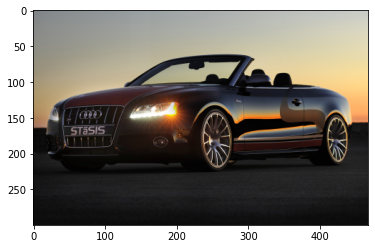

In [31]:
#View the image
item = dataset.iloc[1700].values[0]
print(item)
image =cv.imread(item)
(height, width, channels) = image.shape
print(height)
# some images are too large, resizing to a height of 300 may be ideal
preferedHeight = 300
ratio = preferedHeight/height
width = int(width * ratio)

image = cv.resize(image, (width, preferedHeight), interpolation = cv.INTER_AREA)
# opencv uses bgr to read images, we have to change to rgb
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

plt.imshow(image)

In [32]:
#Preview dataset
dataset.head()

relative_im_path  bbox_x1  bbox_y1  bbox_x2  bbox_y2  class  test
0  car_ims/000001.jpg      112        7      853      717      1     0
1  car_ims/000002.jpg       48       24      441      202      1     0
2  car_ims/000003.jpg        7        4      277      180      1     0
3  car_ims/000004.jpg       33       50      197      150      1     0
4  car_ims/000005.jpg        5        8       83       58      1     0

In [33]:
#returns a square image of prefered dimension
def resizeImage(image,bbox, width, height, prefferedDim):
  x1,y1,x2,y2 = bbox
  bbox_width = x2 - x1
  bbox_height = y2 - y1
  ratio=0
  #pad width
  if height > width:
      newHeight = prefferedDim
      ratio = newHeight/height
      newWidth = int(width *ratio)
      #calculate the difference in width to  the original
      dw = 300 - newWidth
      paddingLeft = paddingRight = 0
      #recalculate starting x coordinate
      x1 = int(x1 * ratio)
      y1 = int(y1*ratio)
      x1 = x1 + int(dw/2)
      #if it is odd, add 1 to the right padding else padding is equal
      if dw%2 == 0: 
        paddingLeft = int(dw/2)
        paddingRight = int(dw/2)
      else:
        paddingLeft = int(dw/2)
        paddingRight = paddingLeft + 1

      image = cv.resize(image, (newWidth, newHeight), interpolation=cv.INTER_AREA)
      image = cv.copyMakeBorder(image, top=0, bottom=0, left=paddingLeft, right=paddingRight, borderType = cv.BORDER_CONSTANT, value= 0)
  else:
    newWidth = prefferedDim
    ratio = newWidth/width
    newHeight = int(height*ratio)
    dh = 300 -newHeight
    paddingTop = paddingBottom = 0
    y1 = int(y1 * ratio)
    x1 = int(x1 * ratio)
    y1 = y1 + int(dh/2)
    if dh%2 == 0:
      paddingTop = int(dh/2)
      paddingBottom = int(dh/2)
    else:
      paddingTop = int(dh/2)
      paddingBottom = paddingTop + 1
    image = cv.resize(image, (newWidth, newHeight), interpolation=cv.INTER_AREA)
    image = cv.copyMakeBorder(image, top=paddingTop, bottom=paddingBottom, left=0, right=0, borderType = cv.BORDER_CONSTANT, value= 0)
  
  #resize the bounding bbox width and height
  bbox_width = int(bbox_width * ratio)
  bbox_height = int(bbox_height * ratio)
  x2 = x1 + bbox_width
  y2 = y1 + bbox_height
  bbox = (x1, y1, x2, y2) 
  return image, bbox


In [34]:
# Create dataLoader, it should take a pandas dataframe as input
class CarDataset(torch.utils.data.Dataset):
  def __init__(self, data):
    self.data = data

  def __getitem__(self, index):
    row = self.data.iloc[index]
    imagePath = row['relative_im_path']
    bbox_x1 = row['bbox_x1']
    bbox_x2 = row['bbox_x2']
    bbox_y1 = row['bbox_y1']
    bbox_y2 = row['bbox_y2']
    # Read image from data path and convert it to tensor
    image = cv.imread(imagePath) 
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    #resize image and add padding if it does not fit
    (height, width, channels) = image.shape
    # resize image and bounding box according to the biggest dimension
    bbox = (bbox_x1, bbox_y1, bbox_x2, bbox_y2)
    image, bbox = resizeImage(image=image,
                              bbox=bbox, 
                        height=height, 
                        width=width, 
                        prefferedDim=300)

    image = torch.from_numpy(image).float()
    image =image.permute(2, 0, 1)
    label = row['class'] - 1
    return image, label, bbox

  def __len__(self):
    return len(self.data)

In [35]:
def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    bbox = [item[2] for item in batch]
    target = torch.LongTensor(target)
    return data, target, bbox

In [37]:
#create the dataset and the data loader
pytorchDataset = CarDataset(dataset)
trainLoader = torch.utils.data.DataLoader(dataset=pytorchDataset, batch_size=20, shuffle=True, collate_fn=my_collate)
image, label, bbox = next(iter(pytorchDataset))
image = image.permute(2,0 , 1 )
images, labels, bboxs = next(iter(trainLoader))


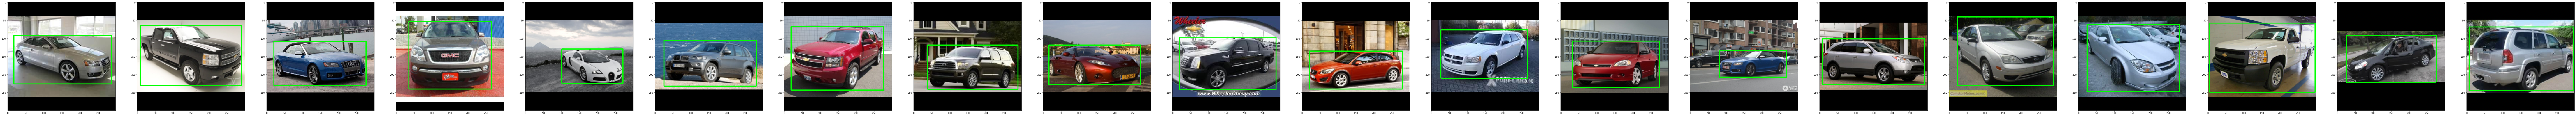

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=20, figsize=(200, 200))
fig.add_gridspec(ncols=5, nrows=2)
for index, (batchImage,bbox) in enumerate(zip(images, bboxs)):
  #plt.imshow(batchImage.permute(1, 2, 0).numpy()/255)
  x1, y1, x2, y2 = bbox
  batchImage = batchImage.permute(1, 2, 0)
  batchImage = batchImage.numpy()
  batchImage = batchImage.astype(np.uint8)
  batchImage = cv.rectangle(batchImage, (x1, y1), (x2, y2), (0,255,0), 2)
  axs[index].imshow(batchImage/255, interpolation='none')

In [41]:
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    #3 input channels, 10outputchannels
    self.conv1 = torch.nn.Conv2d(3, 10, 3)
    self.conv2 = torch.nn.Conv2d(10, 15, 3)
    self.conv3 = torch.nn.Conv2d(15,40, 3)
    self.conv4 = torch.nn.Conv2d(40, 60, 3)
    self.conv5 = torch.nn.Conv2d(60, 80, 3)
    #classification architecture
    self.dropOut1 = torch.nn.Dropout(0.1)
    self.linear1 = torch.nn.Linear(3920, 1000)
    self.dropOut2 = torch.nn.Dropout(0.2)
    self.linear2 = torch.nn.Linear(1000, 1000)
    self.dropOut3 = torch.nn.Dropout(0.1)
    self.linear3 = torch.nn.Linear(1000, 1000)
    self.linear4 = torch.nn.Linear(1000, 196)
    #bounding box architecture
    self.batchNorm1 = torch.nn.BatchNorm1d(num_features=3920)
    self.bboxLinear1 = torch.nn.Linear(3920, 100)
    self.batchNorm2 = torch.nn.BatchNorm1d(num_features=100)
    self.bboxLinear2 = torch.nn.Linear(100, 100)
    self.batchNorm3 = torch.nn.BatchNorm1d(num_features=100)
    self.bboxLinear3 = torch.nn.Linear(100, 4)

  def forward(self, item):
    out = torch.relu(self.conv1(item))
    out = torch.max_pool2d(out, 2)

    out = torch.relu(self.conv2(out))
    out = torch.max_pool2d(out, 2)

    out = torch.relu(self.conv3(out))
    out = torch.max_pool2d(out, 2)
    
    out = torch.relu(self.conv4(out))
    out = torch.max_pool2d(out, 2)

    out = self.conv5(out)
    out = torch.max_pool2d(out, 2)
    
    finalConv = torch.flatten(out, start_dim=1)

    #first network that produces the output classes
    out = self.linear1(finalConv)
    out = torch.relu(out)
    out = self.dropOut1(out)
    out = self.linear2(out)
    out = torch.relu(out)
    out = self.dropOut2(out)
    out = self.linear3(out)
    out = torch.relu(out)
    out = self.dropOut3(out)
    out = self.linear4(out)

    #second linear system that will have outputs for the bounding boxes
    bboxOut = self.batchNorm1(finalConv)
    bboxOut = self.bboxLinear1(bboxOut)
    bboxOut = self.batchNorm2(bboxOut)
    bboxOut = torch.relu(self.bboxLinear2(bboxOut))
    bboxOut = self.batchNorm3(bboxOut)
    bboxOut = self.bboxLinear3(bboxOut)

    return out, bboxOut



In [42]:
#begin training
net = Net()
net.cuda()
lossFunction = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
mseLoss = torch.nn.L1Loss()

epochs  = 25
for epoch in range(epochs):
  batchLosses = list()
  bboxLosses = list()
  trainingAccuracies = list()

  for batch in trainLoader:
    net.train()
    optimizer.zero_grad()
    batchImages, batchLabels, batchBbox = batch
    batchImages =torch.stack(batchImages)
    #batchLabels = torch.stack(batchLabels)
    prediction, bboxPrediction = net(batchImages.cuda())
    #calculate classifier error
    loss = lossFunction(prediction, batchLabels.cuda())
    #calculate bounding box error
    batchBbox = np.asarray(batchBbox).astype(np.float32)
    batchBbox = batchBbox
    batchBbox = torch.from_numpy(batchBbox)
    bboxLoss = mseLoss(bboxPrediction, batchBbox.cuda())
    #do back propagation for bounding boxes and classifier
    #combinedLoss =  loss + 0.01 * bboxLoss
    #print(combinedLoss)
    loss.backward(retain_graph=True)
    bboxLoss = bboxLoss * 0.5
    bboxLoss.backward()
    #combinedLoss.backward()
    optimizer.step()
    #push all losses into a list for later analysis
    batchLosses.append(loss.item())
    bboxLosses.append(bboxLoss.item())
    #torch::Tensor predictedLabel = forwardPass.argmax(1);
    #float isCorrectLabel = predictedLabel.eq(batch.target.squeeze()).sum().item<float>();
    predictedLabel = prediction.argmax(1)
    isCorrectLabel = batchLabels.cpu().eq(predictedLabel.cpu()).float().sum().item()
    trainingAccuracies.append(isCorrectLabel/20)
  epochLoss = torch.tensor(batchLosses).mean().item()
  epochBoundingBoxLoss = torch.tensor(bboxLosses).mean().item()
  epochAccurracy = torch.tensor(trainingAccuracies).mean().item()
  print(f'epoch {epoch + 1} training loss is: {epochLoss:.4f}, bounding box error is {epochBoundingBoxLoss:.4f} , training accurracy is {epochAccurracy:.4f}')
  

epoch 1 training loss is: 5.2786, bounding box error is 76.4136 , training accurracy is 0.0062
epoch 2 training loss is: 5.2742, bounding box error is 64.6156 , training accurracy is 0.0082
epoch 3 training loss is: 5.2503, bounding box error is 12.9129 , training accurracy is 0.0094
epoch 4 training loss is: 5.1630, bounding box error is 4.9314 , training accurracy is 0.0123
epoch 5 training loss is: 4.9574, bounding box error is 4.3482 , training accurracy is 0.0269
epoch 6 training loss is: 4.5913, bounding box error is 4.0695 , training accurracy is 0.0543
epoch 7 training loss is: 4.1543, bounding box error is 3.8930 , training accurracy is 0.0998
epoch 8 training loss is: 3.6538, bounding box error is 3.7482 , training accurracy is 0.1631
epoch 9 training loss is: 3.1201, bounding box error is 3.6795 , training accurracy is 0.2528
epoch 10 training loss is: 2.5772, bounding box error is 3.5744 , training accurracy is 0.3529
epoch 11 training loss is: 2.0626, bounding box error is

In [91]:
test_sample = dataset.sample(5, random_state=85123738)

In [85]:
test_sample.head(n=10)
#get the annotations 
annotations = pd.read_csv('annotations.csv')
annotations[f'class_names{2}'][0]

'Acura RL Sedan 2012'

 Predicted labels
tensor([192,  11,  87,  62, 183])
Actual labels
tensor([192,  11,  87,  62, 183])
5
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


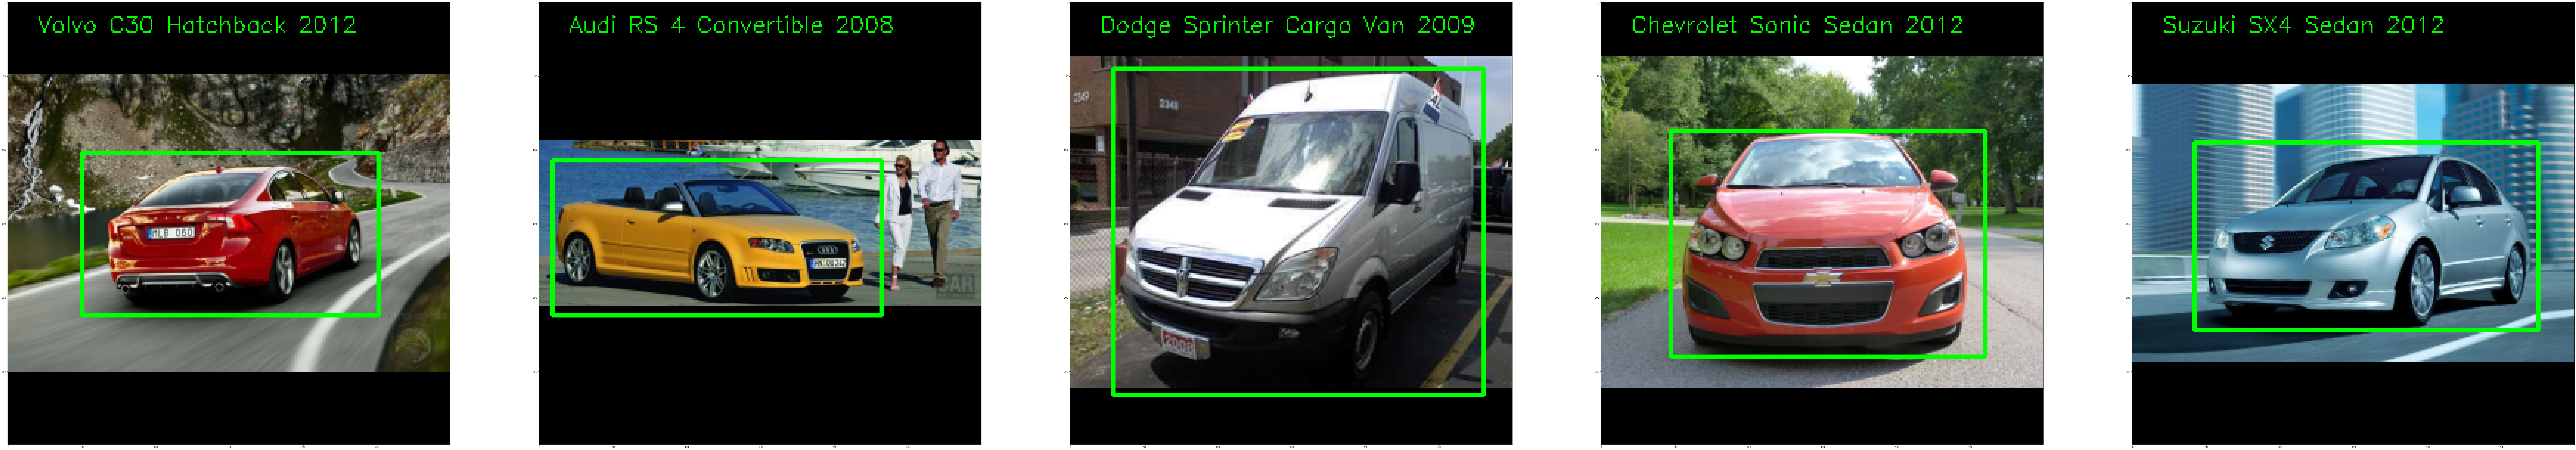

In [92]:
#create dataloader and dataset
testDataset = CarDataset(test_sample)
testLoader = torch.utils.data.DataLoader(dataset=testDataset, batch_size=5, shuffle=True, collate_fn=my_collate)

#put the network in evaluation mode
net.eval()

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(200, 200))
fig.add_gridspec(ncols=5, nrows=1)
batchImages = None
predictions = None
bboxPredictions = None

for batch in testLoader:
  batchImages, batchLabels, batchBbox = batch
  images = torch.stack(batchImages)
  predictions, bboxPredictions = net(images.cuda()) 
  print(' Predicted labels')
  predictions = predictions.cpu().argmax(1)
  bboxPredictions = bboxPredictions.cpu()
  print(predictions)
  print('Actual labels')
  print(batchLabels)

print(len(bboxPredictions))
for index, (batchImage, prediction, bboxPrediction) in enumerate(zip(batchImages, predictions.tolist(), bboxPredictions)):
  batchImage = batchImage.permute(1, 2, 0)
  batchImage = batchImage.numpy()
  batchImage = batchImage.astype(np.uint8)
  label = annotations[f'class_names{prediction + 1}'][0]
  bboxPrediction = bboxPrediction.tolist()
  bboxPrediction = [int(num) for num in bboxPrediction]
  x1, y1, x2, y2 = bboxPrediction
  print(type(x1))
  batchImage = cv.rectangle(batchImage, (x1, y1), (x2, y2), (0,255,0), 2)
  font = cv.FONT_HERSHEY_SIMPLEX
  cv.putText(batchImage, label, (20, 20), font, 0.5,(0, 255, 0, 2))
  axs[index].imshow(batchImage/255, interpolation='none')

In [51]:
torch.save(net, "saved_network")

NameError: ignored

In [52]:
ls

annotations.csv  car_data.csv  car_ims/  car_ims.tgz  saved_network
